<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно. Если делать свертку посимвольно, то можно one-hot-encodingом закодировать каждый символ, если пословно, то каждое слово кодируем, например, word2vec. На выходет получим множество векторов, а стало быть можем сворачивать. Если в тексте оставить достаточое количество начальных символов, то проблема с произвольной длиной входа будет решена.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

Лучше, когда нам важно влияние предыдущего скрытого состояния. Хуже, так как нужно больше данных для обучения.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?


**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

Чтобы backprop шел не на всю длину рекурсии. Плох тем, что полный процессинг рекурсии может быть слишком долгим.

**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Можно подавать выход сверточной сети как первое скрытое состояние для рекуррентной. Это используется, к примеру, в распознавании изображений и классификации видео.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Он не должен быть слишком большим, чтобы похожие по контексту слова были похожими после эмбединга, и не должен быть маленьким, чтобы можно было найти какие-нибудь зависимости.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.64 s, sys: 544 ms, total: 3.18 s
Wall time: 2.92 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import Counter
word_counts = Counter(word for pic in captions for line in pic for word in line[1:-1])  # <here should be dict word:number of entrances>
# not to double START and END
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,  3980,  6254,     2,    -1,    -1],
       [    1,  6766,  1244,  8900,  1022,  9093,  6254,  3980,  8255,
          728,  5915,     2,    -1,    -1,    -1],
       [    1,  8715,  4136, 10056,  9932,  5915,  4859,  6766,  5627,
         8637,   535,  5470,  7115,  5155,     2],
       [    1,  8715,  8895,  3069,  2538,   782,  8715,  8895,  1559,
            2,    -1,    -1,    -1,    -1,    -1],
       [    1,  2852,  7829,  4136, 10056,  9932,  5915,  4859,  6766,
         1244,   535,  5470,  8917,     2,    -1]], dtype=int32)

### Mah Neural Network

In [7]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 * 2 #pls change me if u want
LSTM_UNITS = 700 #pls change me if u want

In [8]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


In [9]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [10]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [11]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [12]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=1e30)

In [13]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10371)

broadcasted decoder shape =  (None, 700)
output shape =  (None, None, 10371)


In [14]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (loss * output_mask).sum() / output_mask.sum()

In [15]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities)
updates = lasagne.updates.adam(loss, weights)

In [16]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

/home/xdr007/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [17]:
captions = np.array(captions)

In [18]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [19]:
generate_batch(img_codes,captions, 3)

(array([[ 0.39180791,  0.51957542,  2.42052674, ..., -4.01853085,
         -3.71693611,  2.65038872],
        [ 0.79782867, -1.9313128 ,  1.06456351, ..., -0.16975927,
          2.27089262,  3.09115791],
        [-4.02579737, -1.01590204,  1.55258763, ..., -4.31837702,
         -0.62724745, -0.11747521]], dtype=float32),
 array([[   1, 6766, 2603, 8900, 5256,  535, 5470, 7115, 5155,    2,   -1,
           -1,   -1],
        [   1, 8715, 9878, 7812,  782, 8715, 4212,  326, 8715, 4363,    2,
           -1,   -1],
        [   1, 8715, 5480, 5899, 8080,  782, 3323, 5742, 4859, 2852, 5899,
         2050,    2]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [20]:
batch_size = 200 #50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [21]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.81936488152, val loss: 5.00737752914


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.67509497643, val loss: 4.31288738251


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.08984484673, val loss: 3.88570618629


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 3.74365147114, val loss: 3.61209788322


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.5905983305, val loss: 3.4937415123


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.46349734783, val loss: 3.43051543236


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.3577350378, val loss: 3.31133565903


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.27384218693, val loss: 3.20687613487


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.19766551971, val loss: 3.16084575653


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.17597514629, val loss: 3.16273818016


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.10295123577, val loss: 3.10373187065


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.07326025486, val loss: 3.10108389854


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.0619832325, val loss: 2.96590628624


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 2.98844428062, val loss: 2.99480605125


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 2.98214931965, val loss: 2.97661762238


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 2.96545467854, val loss: 2.93295836449


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 2.93802402496, val loss: 2.95138115883


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 2.91848758698, val loss: 2.89987878799


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 2.89886453629, val loss: 2.8574277401


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 2.88801802158, val loss: 2.86467766762


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.85040154457, val loss: 2.83947691917


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.83075073719, val loss: 2.82448544502


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 2.80549203396, val loss: 2.79953794479


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.79801558018, val loss: 2.7934466362


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 2.8014302063, val loss: 2.79615983963


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 2.7898051405, val loss: 2.72270832062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 2.76297122955, val loss: 2.73973383904


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 2.76564828396, val loss: 2.71605210304


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.72714805126, val loss: 2.80810003281


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 2.73005663872, val loss: 2.69873771667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.71759008884, val loss: 2.71477389336


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.69419168472, val loss: 2.63934173584


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.69126651287, val loss: 2.66599159241


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.68110430717, val loss: 2.68652448654


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.66839496136, val loss: 2.74882316589


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.6564248085, val loss: 2.67288265228


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.6645878458, val loss: 2.60610375404


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.65365665436, val loss: 2.65894918442


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.63346874714, val loss: 2.64585113525


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.61978341103, val loss: 2.62678847313


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.62941644669, val loss: 2.62545814514


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.61561139107, val loss: 2.58482618332


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.60569190979, val loss: 2.57463884354


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.61306191921, val loss: 2.58867688179


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.61068728447, val loss: 2.61896266937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.59814687252, val loss: 2.57899551392


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.58788798332, val loss: 2.61289496422


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.57411998272, val loss: 2.52780914307


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.57879384041, val loss: 2.63150062561


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.57048471928, val loss: 2.57208218575


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.55649407864, val loss: 2.55423765182


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.57567669868, val loss: 2.5349416256


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.54612294197, val loss: 2.56230707169


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.5696432972, val loss: 2.59699678421


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.5553310442, val loss: 2.52413778305


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.53236840248, val loss: 2.54232845306


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.52606013775, val loss: 2.52345428467


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.54000054359, val loss: 2.50151910782


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.52539637566, val loss: 2.54012441635


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.50917473316, val loss: 2.4966779232


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.51241839409, val loss: 2.47462091446


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.5200420332, val loss: 2.51416506767


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.52125613689, val loss: 2.50355381966


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.50135313988, val loss: 2.47721672058


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.52250524044, val loss: 2.47578878403


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.48118115902, val loss: 2.50704407692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.48472807884, val loss: 2.4858874321


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.47150965691, val loss: 2.43740582466


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.48029970169, val loss: 2.4571161747


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.48258111, val loss: 2.42785568237


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.47457749367, val loss: 2.45762028694


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.48248168468, val loss: 2.46817736626


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.46763795853, val loss: 2.51636567116


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.46293334007, val loss: 2.42972211838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.47379323006, val loss: 2.46215209961


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.46923255444, val loss: 2.39255814552


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.46401319504, val loss: 2.44534454346


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.43302302361, val loss: 2.47465453148


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.44270929337, val loss: 2.47949948311


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.44692621231, val loss: 2.44463715553


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.45369329453, val loss: 2.50995149612


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.44712222576, val loss: 2.4202149868


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.44542605877, val loss: 2.46548213959


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.4227176857, val loss: 2.42549915314


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.41984043121, val loss: 2.43619766235


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.42623194695, val loss: 2.39286699295


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.4301998806, val loss: 2.39898276329


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.40858055115, val loss: 2.47788395882


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.40583204269, val loss: 2.3922162056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.40187693596, val loss: 2.40595784187


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.39827196121, val loss: 2.43770341873


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.41932448387, val loss: 2.43412475586


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.42156994343, val loss: 2.39890146255


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.39887178421, val loss: 2.39836058617


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.40150571346, val loss: 2.41168971062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.3943892622, val loss: 2.37905750275


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.39182944298, val loss: 2.34796900749


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.39399811268, val loss: 2.39832215309


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.39285110474, val loss: 2.34595379829


100%|██████████| 50/50 [00:24<00:00,  1.80it/s]



Epoch: 99, train loss: 2.37925215244, val loss: 2.36419668198
Finish :)


In [22]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 2.38101231098, val loss: 2.32872695923


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 2.39648606777, val loss: 2.39544177055


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 2.38671065807, val loss: 2.41567015648


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 2.38172872543, val loss: 2.36999330521


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 2.38151613235, val loss: 2.44683609009


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 2.38411086082, val loss: 2.37505946159


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 2.35783519268, val loss: 2.3931137085


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 2.37651078701, val loss: 2.41060466766


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 2.37089943886, val loss: 2.35675883293


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 2.35619911194, val loss: 2.32039022446


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 2.35388228893, val loss: 2.34629149437


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 2.33910133839, val loss: 2.4361287117


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 2.35928731918, val loss: 2.37184705734


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 2.34215863228, val loss: 2.38875265121


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 2.37396977901, val loss: 2.31855416298


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 2.35200417519, val loss: 2.3783721447


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 2.35034883976, val loss: 2.38219575882


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 2.35787764549, val loss: 2.34759578705


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 2.34877817631, val loss: 2.32421579361


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 2.33350768566, val loss: 2.35419816971


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.33160236835, val loss: 2.31356348991


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.33609261513, val loss: 2.30947113037


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 2.33167199135, val loss: 2.30848417282


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.32829497337, val loss: 2.35131907463


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 2.31682909966, val loss: 2.35569796562


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 2.32378751755, val loss: 2.34281401634


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 2.31959849358, val loss: 2.31139054298


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 2.31715075493, val loss: 2.3688852787


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.31682467461, val loss: 2.33110842705


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 2.30163148403, val loss: 2.33217945099


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.32802493095, val loss: 2.32722845078


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.31287437916, val loss: 2.36473813057


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.31700764179, val loss: 2.32320699692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.30971927643, val loss: 2.32691030502


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.31327170849, val loss: 2.28003072739


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.31747469902, val loss: 2.29355611801


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.29315403938, val loss: 2.29956731796


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.29075003624, val loss: 2.28171920776


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.30675333023, val loss: 2.31759881973


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.31289525986, val loss: 2.37056632042


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.28882843494, val loss: 2.25608062744


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.29607925415, val loss: 2.33952951431


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.28711309433, val loss: 2.30838246346


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.29589727879, val loss: 2.27397203445


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.27681603909, val loss: 2.25663943291


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.30007304668, val loss: 2.30341954231


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.29164378643, val loss: 2.3205332756


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.27915280819, val loss: 2.32991304398


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.28542773247, val loss: 2.27324090004


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.2841605711, val loss: 2.29747638702


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.2842831707, val loss: 2.24174108505


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.27651135445, val loss: 2.26402854919


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.28089993, val loss: 2.2985730648


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.27296646118, val loss: 2.32846846581


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.27696818352, val loss: 2.30151085854


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.26001607418, val loss: 2.27191839218


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.27889215946, val loss: 2.30067477226


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.26718900681, val loss: 2.25070843697


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.2665384531, val loss: 2.27272415161


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.27364753246, val loss: 2.31481876373


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.25540314674, val loss: 2.29466376305


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.26835327625, val loss: 2.22091879845


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.2605621624, val loss: 2.25690817833


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.26129862785, val loss: 2.37172012329


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.25057193279, val loss: 2.29101147652


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.2660374403, val loss: 2.18734388351


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.25308777332, val loss: 2.24139237404


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.25395768642, val loss: 2.24948992729


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.25820607662, val loss: 2.27771492004


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.24631409645, val loss: 2.22551960945


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.24090125561, val loss: 2.24162054062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.25250605583, val loss: 2.25959658623


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.24813855648, val loss: 2.18956418037


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.25785965919, val loss: 2.22054715157


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.24370955944, val loss: 2.27587823868


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.24028692245, val loss: 2.27080001831


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.23546026707, val loss: 2.23960080147


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.23369223595, val loss: 2.2001991272


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.23392171383, val loss: 2.25077834129


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.23764365673, val loss: 2.18537716866


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.23107028961, val loss: 2.22226176262


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.23360536575, val loss: 2.20295877457


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.23994641304, val loss: 2.26341471672


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.23307347775, val loss: 2.19062819481


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.22577251434, val loss: 2.20416750908


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.23190262318, val loss: 2.23615684509


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.22451450348, val loss: 2.16374583244


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.22426902771, val loss: 2.19861283302


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.2035436964, val loss: 2.17390503883


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.2208070755, val loss: 2.18132414818


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.22652175903, val loss: 2.24044308662


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.22538672447, val loss: 2.19414491653


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.20469379902, val loss: 2.24295668602


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.2204221487, val loss: 2.21929912567


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.22491072178, val loss: 2.24669055939


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.22798586369, val loss: 2.23388023376


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.20344733238, val loss: 2.22837762833


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.21711071014, val loss: 2.25038824081


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.20190551281, val loss: 2.19828271866


100%|██████████| 50/50 [00:22<00:00,  2.05it/s]



Epoch: 99, train loss: 2.19851107121, val loss: 2.19447603226
Finish :)


### apply trained model

In [28]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

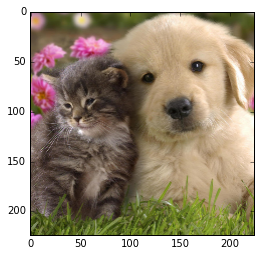

In [30]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [37]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [38]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

there is some black and white dog on a couch
a old black and white cat resting on top of a stuffed animal
a big black and white cat is laying on a large wood
mother and white baby chewing on white plate
adult two black and white panda holding up to their mouth
there is a short black and white cat and a white color orange
brown and black and white cockatoo walking through a white wall
cute little looking up with four #UNK# hands of the cat
woman is on display with multi colored cake
a couple of cats in a tan black background


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 